In [105]:
'''Start with KNN, KMeans clustering may be better though!'''

import numpy as np
import statsmodels.api as sm
import pandas as pd
import pandas_datareader as pdr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import mglearn

In [ ]:
'''BEGIN IB_INSYNC (unless better data option, ideally?)'''
import os
#Pull with IB ? Need to, don't see another way
from ib_insync import *

ib = IB()


ib.connect('127.0.0.1', 7497, clientId=1)

In [ ]:
#contract = Stock('AAPL','SMART','USD')
#contract = Forex('EURUSD')

In [ ]:
bars = ib.reqHistoricalData(contract,endDateTime='', durationStr='30 D',
    barSizeSetting='1 hour', whatToShow='TRADES', useRTH=True)

In [ ]:
'''Can derive spread using huge algo, append on, and the rest is technical...'''

import alpaca_trade_api as tradeapi


ep = 'https://paper-api.alpaca.markets'
api_key = 'PK4LB1H4BH7YUF4XOODN'
secret_key = '7EuTmI/C/7FwtNkEzqzFD7yiVMqaI16XfuerzHgR'

api = tradeapi.REST(base_url = ep, key_id = api_key, secret_key=secret_key)
acct = api.get_account()


def get_tickers(min_price=5,max_price=50,etb=False):
    print('Getting current ticker data...')
    tickers = api.polygon.all_tickers() #ALLLLLL SYMBOLS ! 
    print('All symbols loaded')
    assets = api.list_assets()
    if etb: #FILTER TRADABLE SYMBOLS; easy to borrow if switch True
        symbols = [asset.symbol for asset in assets if asset.tradable and asset.easy_to_borrow]
    else:
        symbols = [asset.symbol for asset in assets if asset.tradable] 
    #print(tickers)
    return [ticker for ticker in tickers if (
        ticker.ticker in symbols and
        ticker.lastTrade['p'] >= min_price and
        ticker.lastTrade['p'] <= max_price and
        ticker.prevDay['v'] * ticker.lastTrade['p'] > 500000 #and
        #ticker.todaysChangePerc >= 3.5
    )]

XL = get_tickers(500,10000)
print(f'XTRA large -- (500-10k): {len(XL)}')
XL_list = [XL.ticker for XL in XL]
XL_list


In [ ]:
'''
assets = api.list_assets()
easy_tb = [asset.symbol for asset in assets if asset.easy_to_borrow]
symbol_list = [ticker.ticker for ticker in tickers if ticker.ticker in easy_tb]
print('Small:',len(symbol_list))

tickers[0]

#FIND BID ASK P and p in lastQuote

tickers[0]#['lastQuote'] #['P']
'''

In [ ]:
def create_universal_df(ticker):
    tmp = api.polygon.historic_agg('day',ticker,limit=100).df.reset_index()
    tmp['ticker'] = str(ticker)
    return tmp

def concat_agg_dfs(a,b):
    '''Must have ticker column, numbered idx'''
    #a.set_index('ticker')
    cct = pd.concat([a,b],axis=0)
    return cct

def get_universe(min_price,max_price):
    tickers = get_tickers(500,1000)
    symlist = [t.ticker for t in tickers]
    a = symlist[0] 
    A = create_universal_df(a) #Univ DF (maybe make this a global?)
    
    symlist = symlist[1:] #dont need to first symbol, used to create univ df
    for i in symlist:
        b = create_universal_df(i)
        multi = concat_agg_dfs(A,b) 
        A = multi #Merge instance df w universal df, and assign to scoped var
    A = A.set_index(['ticker','day'])
    
    return A

In [85]:
def getBeta(series,sl): 
    hl=series[['High','Low']].values 
    hl=np.log(hl[:,0]/hl[:,1])**2 
    hl=pd.Series(hl,index=series.index) 
    beta = hl.rolling(window=2).sum()
    beta = beta.rolling(window=sl).mean()
    return beta.dropna()


def getGamma(series): 
    #h2= pandas.stats.moments.rolling_max(series['High'],window=2)
    h2 = series.High.rolling(window=2).max()
    #l2=pd.stats.moments.rolling_min(series['Low'],window=2) #Deprecated
    l2 = series.Low.rolling(window=2).min()
    gamma=np.log(h2.values/l2.values)**2 
    gamma=pd.Series(gamma,index=h2.index)
    return gamma.dropna()

def getAlpha(beta,gamma):
    den = 3 -2*2**.5
    alpha = (2**.5-1)*(beta**.5)/den
    alpha -= (gamma/den)**.5
    alpha[alpha<0] = 0 #Set neg alphas to 0
    return alpha.dropna()

def corwinSchultz(series,sl=1):
    # Note: S<0 iif alpha<0
    beta=getBeta(series,sl)
    gamma=getGamma(series)
    alpha=getAlpha(beta,gamma)
    spread=2*(np.exp(alpha)-1)/(1+np.exp(alpha)) 
    startTime=pd.Series(series.index[0:spread.shape[0]],index=spread.index) 
    spread=pd.concat([spread,startTime],axis=1) 
    spread.columns=['Spread','Start_Time'] # 1st loc used to compute beta 
    return spread 

def calcSpread(ticker,type='mean',top=50):
    import pandas_datareader as pdr
    sec = pdr.DataReader(ticker,data_source='yahoo',start='2019-01-01')
    sp = corwinSchultz(sec)
    sprd = sp.sort_values(by='Spread',ascending=False)
    if type == 'mean': return sprd.Spread.head(top).mean()
    if type == 'median': return sprd.Spread.head(top).median()
    if type == 'max': return sprd.Spread.max()
    return 0

calcSpread('TSLA')



0.023519579909469592

In [77]:
SEC_LIST = ['TSLA','ROKU','INTC','CRM','BYND','MDB']
DF = pdr.DataReader('AMD','yahoo','2019')
DF['ticker'] = 'AMD'
DF['ATR'] = ta.ATR(DF['High'],DF['Low'],DF['Close'],14)
DF['MA'] = DF.Close.rolling(window=20).mean()
DF['STD'] = DF.Close.rolling(window=20).std()
#DF['Spread'] = calcSpread(i)

for i in SEC_LIST:
    df = pdr.DataReader(i,'yahoo','2019')
    df['ticker'] = str(i)
    df['ATR'] = ta.ATR(df['High'],df['Low'],df['Close'],14)
    df['MA'] = df.Close.rolling(window=20).mean()
    df['STD'] = df.Close.rolling(window=20).std()
    df['Spread'] = calcSpread(i)
    #print(df.Spread)
    tmp = pd.concat([DF,df],axis=0)
    DF = tmp
    
DF

Date
2019-01-02    0.02352
2019-01-03    0.02352
2019-01-04    0.02352
2019-01-07    0.02352
2019-01-08    0.02352
               ...   
2020-02-05    0.02352
2020-02-06    0.02352
2020-02-07    0.02352
2020-02-10    0.02352
2020-02-11    0.02352
Name: Spread, Length: 280, dtype: float64


/Users/zoakes/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Date
2019-01-02    0.038783
2019-01-03    0.038783
2019-01-04    0.038783
2019-01-07    0.038783
2019-01-08    0.038783
                ...   
2020-02-05    0.038783
2020-02-06    0.038783
2020-02-07    0.038783
2020-02-10    0.038783
2020-02-11    0.038783
Name: Spread, Length: 280, dtype: float64
Date
2019-01-02    0.012236
2019-01-03    0.012236
2019-01-04    0.012236
2019-01-07    0.012236
2019-01-08    0.012236
                ...   
2020-02-05    0.012236
2020-02-06    0.012236
2020-02-07    0.012236
2020-02-10    0.012236
2020-02-11    0.012236
Name: Spread, Length: 280, dtype: float64
Date
2019-01-02    0.015227
2019-01-03    0.015227
2019-01-04    0.015227
2019-01-07    0.015227
2019-01-08    0.015227
                ...   
2020-02-05    0.015227
2020-02-06    0.015227
2020-02-07    0.015227
2020-02-10    0.015227
2020-02-11    0.015227
Name: Spread, Length: 280, dtype: float64
Date
2019-05-02    0.039344
2019-05-03    0.039344
2019-05-06    0.039344
2019-05-07    0.039344
201

,ATR,Adj Close,Close,High,Low,MA,Open,STD,Spread,Volume,ticker
Date,,,,,,,,,,,
2019-01-02,NaN,18.830000,18.830000,19.000000,17.980000,NaN,18.010000,NaN,NaN,87148700.0,AMD
2019-01-03,NaN,17.049999,17.049999,18.680000,16.940001,NaN,18.420000,NaN,NaN,117277600.0,AMD
2019-01-04,NaN,19.000000,19.000000,19.070000,17.430000,NaN,17.549999,NaN,NaN,111878600.0,AMD
2019-01-07,NaN,20.570000,20.570000,20.680000,19.000000,NaN,19.440001,NaN,NaN,107157000.0,AMD
2019-01-08,NaN,20.750000,20.750000,21.200001,19.680000,NaN,21.190001,NaN,NaN,121271000.0,AMD
...,...,...,...,...,...,...,...,...,...,...,...
2020-02-05,7.181468,163.210007,163.210007,173.800003,160.289993,154.443501,173.800003,7.846018,0.035851,1259700.0,MDB
2020-02-06,7.277078,163.610001,163.610001,167.520004,159.000000,155.610501,164.539993,7.346818,0.035851,596100.0,MDB
2020-02-07,7.134429,164.110001,164.110001,166.300003,161.020004,156.318001,164.399994,7.454568,0.035851,522200.0,MDB


In [80]:
'''Make copies!'''
#DF = DF.set_index('ticker')
df2 = DF
df3 = DF

In [83]:
DF #= DF.reset_index().set_index(['Date','ticker'])
DF.loc['AMD','Spread'] = calcSpread('AMD')
DF.fillna(0)

,ATR,Adj Close,Close,High,Low,MA,Open,STD,Spread,Volume
ticker,,,,,,,,,,
AMD,NaN,18.830000,18.830000,19.000000,17.980000,NaN,18.010000,NaN,0.024959,87148700.0
AMD,NaN,17.049999,17.049999,18.680000,16.940001,NaN,18.420000,NaN,0.024959,117277600.0
AMD,NaN,19.000000,19.000000,19.070000,17.430000,NaN,17.549999,NaN,0.024959,111878600.0
AMD,NaN,20.570000,20.570000,20.680000,19.000000,NaN,19.440001,NaN,0.024959,107157000.0
AMD,NaN,20.750000,20.750000,21.200001,19.680000,NaN,21.190001,NaN,0.024959,121271000.0
...,...,...,...,...,...,...,...,...,...,...
MDB,7.181468,163.210007,163.210007,173.800003,160.289993,154.443501,173.800003,7.846018,0.035851,1259700.0
MDB,7.277078,163.610001,163.610001,167.520004,159.000000,155.610501,164.539993,7.346818,0.035851,596100.0
MDB,7.134429,164.110001,164.110001,166.300003,161.020004,156.318001,164.399994,7.454568,0.035851,522200.0


In [68]:
'''df = DF.reset_index()
dfg = df.groupby(['ticker'])['High','Low','Open','Close']
dfg.head()'''

,High,Low,Open,Close
0,19.000000,17.980000,18.010000,18.830000
1,18.680000,16.940001,18.420000,17.049999
2,19.070000,17.430000,17.549999,19.000000
3,20.680000,19.000000,19.440001,20.570000
4,21.200001,19.680000,21.190001,20.750000
279,315.130005,298.799988,306.100006,310.119995
280,309.399994,297.380005,307.000000,300.359985
281,318.000000,302.730011,306.000000,317.690002
282,336.739990,317.750000,321.720001,334.959991
283,344.010010,327.019989,341.959991,335.350006


In [37]:
DF.loc['2020-02-04','AMD']
#DF.loc[,'AMD'] Dont know how to slice multiindex?!

High         4.975000e+01
Low          4.861000e+01
Open         4.921000e+01
Close        4.945000e+01
Volume       4.630210e+07
Adj Close    4.945000e+01
Name: (2020-02-04 00:00:00, AMD), dtype: float64

In [54]:
'''import talib as ta

DF['ATR'] = ta.ATR(DF['High'],DF['Low'],DF['Close'],14)
DF['MA'] = DF.Close.rolling(window=20).mean()
DF['STD'] = DF.Close.rolling(window=20).std()
'''

In [89]:
'''Begin machine learning algo!'''
DF = DF.fillna(0)
spread = DF['Spread']
atr = DF['ATR']
std = DF['STD']
o = DF['Open']
c = DF['Close']
v = DF['Volume']

y = spread
x = np.column_stack((atr,std,o,c,v))
x = sm.add_constant(x,prepend=True)

In [111]:
'''MUST ENCODE LABELS FOR TARGET'''
from sklearn import utils
lab_enc = LabelEncoder()
encoded = lab_enc.fit_transform(y)
#array([1, 3, 2, 0], dtype=int64)
y = encoded

print(utils.multiclass.type_of_target(encoded))
print('BINGO -- no longer continuous')

multiclass
BINGO -- no longer continuous


In [90]:
x_scaled = MinMaxScaler().fit_transform(x)

In [92]:
x_scaled

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.31541096e-04,
        2.04595429e-03, 4.11793189e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00530479e-03,
        0.00000000e+00, 5.54399350e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        2.24135443e-03, 5.28844794e-01],
       ...,
       [0.00000000e+00, 1.23177791e-01, 6.56116037e-02, 1.69688345e-01,
        1.69032542e-01, 1.77248938e-03],
       [0.00000000e+00, 1.21269438e-01, 6.66572165e-02, 1.68821704e-01,
        1.71492283e-01, 1.64232633e-03],
       [0.00000000e+00, 1.17664709e-01, 6.83213273e-02, 1.72507821e-01,
        1.71469290e-01, 0.00000000e+00]])

In [112]:
x_train,x_test,y_train,y_test = train_test_split(x_scaled,y,test_size=0.2)
x_train.shape

(1501, 6)

In [115]:
'''Cant be floats? wht the fuck are they supposed to be then? -- use LabelEncoder()'''
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(x_train,y_train)
print(f'Test set score:{knn.score(x_test,y_test)}')

Test set score:0.9547872340425532


/Users/zoakes/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function make_blobs is deprecated; Please import make_blobs directly from scikit-learn
  warnings.warn(msg, category=FutureWarning)


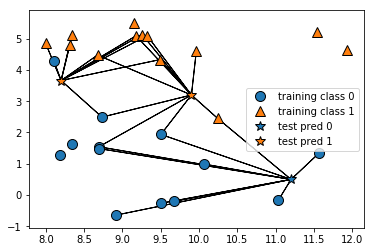

In [118]:
mglearn.plots.plot_knn_classification(n_neighbors=10)
plt.show()